In [1]:
import os
import torch
from torchvision.datasets.utils import download_url
from torchtext import data
from torchtext import datasets
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import models

In [3]:
SEED = 2
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Load data

In [30]:
# Read data - short version 3400+ documents
reuters = pd.read_pickle('input/reuters_small.pkl')
print(len(reuters))
reuters[0:2]

3426


,codes,headline,text,classes,classes_pad
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


In [5]:
# 8x small size
#reuters = pd.read_pickle('input/reuters_small8.pkl')
print(len(reuters))
reuters[0:2]

3426


,codes,headline,text,classes,classes_pad
0,"[C18, C181, CCAT]",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[G15, GCAT]",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


In [6]:
# load full data, if produced. 435 MB. NOT in Github currently. 
# You can produce this in about 30 min with preprocess_data.ipynb

#reuters = pd.read_pickle('input/reuters_all.pkl')

In [31]:
# read classcodes
classcodes= pd.read_csv('input/classcodes.csv')
print(len(classcodes))
#classcodes[0:12]

# add index field to DataFrame
classcodes = classcodes.reset_index()
# Create dictionary index/int to classcode and classcode to int
itocode = dict(zip(classcodes.index, classcodes.Code))
codetoi = dict(zip(classcodes.Code, classcodes.index))
def listToInt(mylist):
    return [codetoi[item] for item in mylist]

reuters['codes'] = [listToInt(codelist) for codelist in reuters.codes]
reuters[0:3]
# Multihot, for single list - one row
def multihot(tags):
    return [1 if tag in tags else 0 for tag in taglist]

# list of classes, 126 int: [0...125]
taglist = list(classcodes.index)
Y_hot = [multihot(claslist) for claslist in reuters.codes]
reuters['codes'] = Y_hot

126


In [32]:
print(len(reuters))
reuters[0:3]

3426


,codes,headline,text,classes,classes_pad
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Eureko is latest suitor for French insurer GAN.,"\nEureko, an alliance of six European financia...","[25, 26, 44]","[25, 26, 44, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Reuter EC Report Long-Term Diary for July 28 -...,\n****\nHIGHLIGHTS\n****\nLUXEMBOURG - Luxembo...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Official Journal contents - OJ L 190 of July 1...,\n*\n(Note - contents are displayed in reverse...,"[80, 90]","[80, 90, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]"


### Using DataSet


Example in:
https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/A%20-%20Using%20TorchText%20with%20Your%20Own%20Datasets.ipynb

In [33]:
#Define the Fields
TEXT = data.Field()
HEADLINE = data.Field()
LABELS = data.LabelField(sequential=False, use_vocab=False)

In [34]:
# Put data in random order
idx = np.random.permutation(len(reuters))
reuters = reuters.iloc[idx]

In [35]:
# split it
size = len(reuters)
train_size = int(0.7*size)
test_size = int(0.85*size)

train = reuters[0: train_size]
val = reuters[train_size : test_size]
test = reuters[test_size : size]

train.to_json('input/train.json', orient='records', lines=True)
test.to_json('input/test.json', orient='records', lines=True)
val.to_json('input/val.json', orient='records', lines=True)

In [36]:
# Tell torchText which Fields to apply to which json elements

fields = {'headline': ('h', HEADLINE), 'text': ('t', TEXT), 'codes': ('l', LABELS)}
fields

{'headline': ('h', <torchtext.data.field.Field at 0x7fb63a114710>),
 'text': ('t', <torchtext.data.field.Field at 0x7fb63a1147b8>),
 'codes': ('l', <torchtext.data.field.LabelField at 0x7fb63a114898>)}

In [37]:
# Create dataset (TabularDataset)
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'input',
                                        train = 'train.json',
                                        validation = 'val.json',
                                        test = 'test.json',
                                        format = 'json',
                                        fields = fields
)
# test
#print(vars(train_data[2]))

### continue

In [38]:
# GLOVE

#TEXT.build_vocab(train)
TEXT.build_vocab(train_data, max_size=25000, vectors="glove.6B.50d")
HEADLINE.build_vocab(train)
LABELS.build_vocab(train)

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 50])


In [39]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')
print('------------')
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABELS vocabulary: {len(LABELS.vocab)}")

Number of training examples: 2398
Number of validation examples: 514
Number of testing examples: 514
------------
Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABELS vocabulary: 5


In [40]:
print(TEXT.vocab.freqs.most_common(10))
print('-----')
print(TEXT.vocab.itos[:10])
print(LABELS.vocab.stoi)

[('the', 22262), ('of', 12421), ('to', 11940), ('in', 9559), ('and', 9135), ('a', 8693), ('on', 5601), ('said', 4436), ('for', 4038), ('The', 3613)]
-----
['<unk>', '<pad>', 'the', 'of', 'to', 'in', 'and', 'a', 'on', 'said']
defaultdict(<function _default_unk_index at 0x7fb6b8ee9d08>, {'classes': 0, 'classes_pad': 1, 'codes': 2, 'headline': 3, 'text': 4})


In [41]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    sort_key= lambda x: len(x.t)
)

### F1 accuracy

The results will be ranked according to the highest micro-averaged F1 score. 
This will be calculated using the f1_score function found in scikit-learn, using a command like 
f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred 
the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document
i contains the label j.

Scikit:  Micro-average in F1-score
 
'micro':
    Calculate metrics globally by counting the total true positives, false negatives and false positives.

In [42]:
# f1 score for BATCH
from sklearn.metrics import f1_score
def f1_accuracy(preds, y):
    """
    Returns f1 accuracy from sklearn
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    
    preds_cpu = rounded_preds.cpu().data.numpy()
    y_cpu = y.cpu().data.numpy()
    f1 = f1_score(y_cpu, preds_cpu, average='micro')
    return f1 

In [43]:
def f1_own_accuracy(preds, y):
    '''Returns counts of true_pos, false_pos and false_negative.
    For counting precision, recall and F1 globally
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    '''
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    
    preds = rounded_preds.cpu().data.numpy()
    y = y.cpu().data.numpy()
        
    # True positive
    tpos = np.sum(np.logical_and(preds == 1, y == 1))
 
    # True negative
    #tneg = np.sum(np.logical_and(preds == 0, y == 0))
 
    # False positive
    fpos = np.sum(np.logical_and(preds == 1, y == 0))
 
    # False negative
    fneg = np.sum(np.logical_and(preds == 0, y == 1))

    return tpos, fpos, fneg

In [44]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum()/len(correct)
    return acc

In [45]:
# F1 version
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0
    
    model.train()
    
    for batch in iterator:
        if batch.t.shape[1] != BATCH_SIZE:
              continue
        
        optimizer.zero_grad()
                
        predictions = model(batch.t).squeeze(1)
        
        loss = criterion(predictions, batch.l.float())
        
        tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
        epoch_tpos += tpos
        epoch_fpos += fpos
        epoch_fneg += fneg
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        #epoch_acc += acc.item()
    
    # Counted f1-score is Micro-average version
    # avoid div by zero with epsilon
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps )
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +eps))
    
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

In [46]:
# F1 version
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    #epoch_acc = 0
    epoch_tpos = 0
    epoch_fpos = 0
    epoch_fneg = 0    
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:
            if batch.t.shape[1] != BATCH_SIZE:
                continue

            predictions = model(batch.t).squeeze(1)
            
            loss = criterion(predictions, batch.l.float())
            
            tpos, fpos, fneg = f1_own_accuracy(predictions, batch.l.float())
            epoch_tpos += tpos
            epoch_fpos += fpos
            epoch_fneg += fneg            

            epoch_loss += loss.item()
            #epoch_acc += acc.item()

    # avoid div by zero with epsilon
    eps = 1e-7
    epoch_precision = epoch_tpos / (epoch_tpos + epoch_fpos +eps)
    epoch_recall = epoch_tpos / (epoch_tpos + epoch_fneg +eps)
    epoch_f1 = 2* (  ((epoch_precision * epoch_recall)+eps) / (epoch_precision + epoch_recall +eps))            
        
    return epoch_loss / len(iterator), epoch_precision, epoch_recall, epoch_f1

### Load model

In [23]:
#import models
#from models import *

# Common
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 50
OUTPUT_DIM = 126

In [54]:
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

### OR

In [113]:
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [56]:
N_FILTERS = 200
FILTER_SIZES = [3,5,7]
DROPOUT = 0.5

model = models.CNN2(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

# 14 epochs gave f1 0.84

In [103]:
# or LSTM
HIDDEN_DIM = 250
OUTPUT_DIM = 126
N_EPOCHS = 50
N_LAYERS = 1
BIDIRECTIONAL = False

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

model = models.LSTM(INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS, BIDIRECTIONAL, device)
model.hidden = model.init_hidden(64)


model.embedding.weight.data.copy_(TEXT.vocab.vectors)


optimizer = optim.SGD(model.parameters(), lr=0.02)
# optimizer = optim.Adam(model.parameters(), lr=0.01)




In [116]:
# COMMON
model = model.to(device)
model.embedding.weight.data.copy_(pretrained_embeddings)

#optimizer = optim.SGD(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

# Reset 
train_losses=[]
train_f1s=[]
val_losses=[]
val_f1s=[]

In [49]:
# Store results of training
results = pd.DataFrame()

### Train

In [119]:
# Ver2 - F1
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(epoch)

    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss); train_f1s.append(train_f1)
    val_losses.append(valid_loss); val_f1s.append(valid_f1)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

0
| Ep:01 |Tr Loss:0.022 |Prec:0.929 |Rec:0.766 |f1:0.840 |Val Loss:0.032 |prec:0.886 |rec:0.622 |f1:0.731 |
1
| Ep:02 |Tr Loss:0.020 |Prec:0.934 |Rec:0.784 |f1:0.853 |Val Loss:0.032 |prec:0.881 |rec:0.635 |f1:0.738 |
2
| Ep:03 |Tr Loss:0.020 |Prec:0.941 |Rec:0.785 |f1:0.856 |Val Loss:0.032 |prec:0.881 |rec:0.630 |f1:0.735 |
3
| Ep:04 |Tr Loss:0.019 |Prec:0.940 |Rec:0.796 |f1:0.862 |Val Loss:0.032 |prec:0.876 |rec:0.642 |f1:0.741 |
4
| Ep:05 |Tr Loss:0.018 |Prec:0.947 |Rec:0.809 |f1:0.873 |Val Loss:0.032 |prec:0.874 |rec:0.639 |f1:0.738 |
5
| Ep:06 |Tr Loss:0.018 |Prec:0.942 |Rec:0.811 |f1:0.871 |Val Loss:0.032 |prec:0.873 |rec:0.642 |f1:0.740 |
6
| Ep:07 |Tr Loss:0.017 |Prec:0.944 |Rec:0.818 |f1:0.877 |Val Loss:0.032 |prec:0.877 |rec:0.646 |f1:0.744 |
7
| Ep:08 |Tr Loss:0.016 |Prec:0.953 |Rec:0.833 |f1:0.889 |Val Loss:0.032 |prec:0.881 |rec:0.649 |f1:0.748 |
8
| Ep:09 |Tr Loss:0.016 |Prec:0.949 |Rec:0.836 |f1:0.889 |Val Loss:0.032 |prec:0.871 |rec:0.652 |f1:0.746 |
9
| Ep:10 |Tr Loss:

In [ ]:
# Ver2 - F1
N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    print(epoch)

    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

In [ ]:
# Ver2 - F1
N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    print(epoch)

    train_loss, train_precision, train_recall, train_f1 = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_iterator, criterion)
    
    #print(f'| Epoch:{epoch+1:02} | Train Loss: {train_loss:.3f} | Tr Precision: {train_precision:.3f} | Tr recall: {train_recall:.3f} | Tr f1: {train_f1:.3f} | Valid f1: {valid_f1:.3f} |')    
    print(f'| Ep:{epoch+1:02} |Tr Loss:{train_loss:.3f} |Prec:{train_precision:.3f} |Rec:{train_recall:.3f} |f1:{train_f1:.3f} |Val Loss:{valid_loss:.3f} |prec:{valid_precision:.3f} |rec:{valid_recall:.3f} |f1:{valid_f1:.3f} |')        

### Results

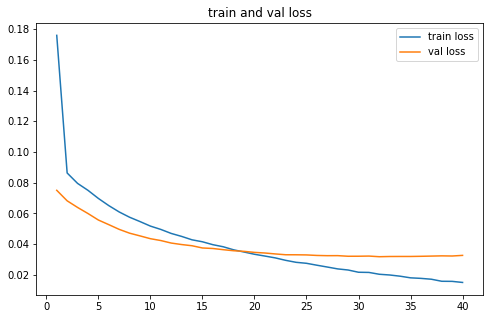

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline
epochs = len(train_losses)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_losses, label='train loss')
plt.plot(np.arange(1,epochs+1), val_losses, label='val loss')
plt.title('train and val loss')
plt.legend()

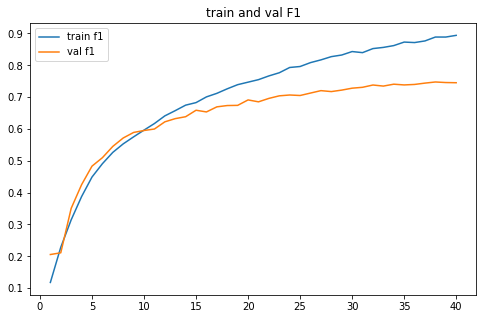

In [121]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,epochs+1), train_f1s, label='train f1')
plt.plot(np.arange(1,epochs+1), val_f1s, label='val f1')
plt.title('train and val F1')
plt.legend()

In [102]:
### Save it
#results = pd.DataFrame()


In [122]:
model_name = type(model).__name__
model_name

'CNN2'

In [123]:
results = results.append({'Model': model_name, 'Train_loss': pd.DataFrame({'Train_loss':train_losses}), 
                                         'Train_f1': pd.DataFrame({'Train_f1':train_f1s}), 
                                         'Val_loss': pd.DataFrame({'Val_loss':val_losses}), 
                                         'Val_f1': pd.DataFrame({'Val_f1':val_f1s})  }, ignore_index=True)

results

,Model,Train_f1,Train_loss,Val_f1,Val_loss
0,LSTM,Train_f1 0 0.060967 1 0.169078 2 0.1...,Train_loss 0 0.260565 1 0.084155 2...,Val_f1 0 2.000000 1 0.242737 2 0.2...,Val_loss 0 0.077882 1 0.073089 2 0.0...
1,CNN2,Train_f1 0 0.117869 1 0.228364 2 0.3...,Train_loss 0 0.175908 1 0.086339 2...,Val_f1 0 0.205588 1 0.210984 2 0.3...,Val_loss 0 0.075070 1 0.068228 2 0.0...


In [126]:
results.to_pickle('results.pkl')

In [127]:
res = pd.read_pickle('results.pkl')

In [129]:
res

,Model,Train_f1,Train_loss,Val_f1,Val_loss
0,LSTM,Train_f1 0 0.060967 1 0.169078 2 0.1...,Train_loss 0 0.260565 1 0.084155 2...,Val_f1 0 2.000000 1 0.242737 2 0.2...,Val_loss 0 0.077882 1 0.073089 2 0.0...
1,CNN2,Train_f1 0 0.117869 1 0.228364 2 0.3...,Train_loss 0 0.175908 1 0.086339 2...,Val_f1 0 0.205588 1 0.210984 2 0.3...,Val_loss 0 0.075070 1 0.068228 2 0.0...


In [137]:
len(res['Train_f1'][1])

40

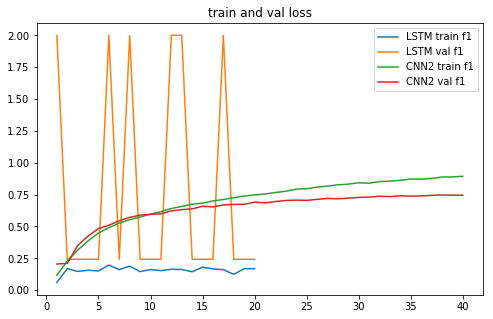

In [146]:
#epochs = len(train_losses)
epochs = 40

plt.figure(figsize=(8,5))

epochs = len(res['Train_f1'][0])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][0], label=res['Model'][0] +' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][0], label=res['Model'][0] +' val f1')

epochs = len(res['Train_f1'][1])
plt.plot(np.arange(1,epochs+1), res['Train_f1'][1], label=res['Model'][1]+ ' train f1')
plt.plot(np.arange(1,epochs+1), res['Val_f1'][1], label=res['Model'][1] + ' val f1')




plt.title('train and val loss')
plt.legend()

In [143]:
res['Model'][0]

'LSTM'

### Save the model

For this version create the model object with same paramters as when training. Then load weights.
This version saves also gradients etc.

In [ ]:
torch.save(model.state_dict(), 'model.pkl')
#torch.save(model, 'filename.pt')

In [ ]:
model2 = RNN(input_dim=25002, embedding_dim=50, hidden_dim=256, output_dim=126)

In [ ]:
model2.load_state_dict(torch.load('model.pkl'))
                      

In [ ]:
model2.eval()

#### easier but not so compatible
This version does not save the gradients, only final model. 
Here you dont ened to create model object frist.

In [ ]:
torch.save(model, 'modelx.pt')


In [ ]:
modelx = torch.load('modelx.pt')

### Test it on test data

In [ ]:
test_loss, test_precision, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} ||Prec:{test_precision:.3f} |Rec:{test_recall:.3f} |Test F1:{test_f1: .3f} |')

### Use final scoring 

The results will be ranked according to the highest micro-averaged F1 score. This will be calculated using the f1_score function found in scikit-learn, using a command like f1_score(y_true, y_pred, average='micro') where y_true is the matrix with the ground truth, and y_pred the predicted output. Both matrices are binary, a 1 in row i and column j means that the image/document i contains the label j.

In [ ]:
from sklearn.metrics import f1_score
f1_score()